<a href="https://colab.research.google.com/github/0ethel0zhang/quantcon2022/blob/main/ML_TLC_w_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

You can refer to [this TensorFlow tutorial](https://www.tensorflow.org/hub/tutorials/tf2_text_classification) on how to import the data.

# 0. Setup

## 0.1 Install libraries

In [1]:
#@title NOT NEEDED if not running PaLM. PaLM is currently only available within US. </br> Process PALM <br/> <br/>[NOTE] Uncomment and run the first time you start the runtime. Runtime needs to be restarted after the initial installation
! pip install -U google-generativeai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.3/113.3 kB 9.5 MB/s eta 0:00:00


In [5]:
! pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.3 MB/s eta 0:00:00


## 0.2 Import Libraries

In [1]:
import numpy as np
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is NOT AVAILABLE


In [2]:
import google.generativeai as palm

In [6]:
from google.colab import output
import builtins

In [7]:
import os
import time
import openai
from openai.embeddings_utils import get_embedding
openai.organization = "org-jv3Ely1HtldcQOxKuEWTvRJp"

In [ ]:
#@title choose embedding / summarization model
choose_model = "gpt" #@param ["ulm", "nnlm", "palm", "gpt"]

##0.3 Set up access keys if needed

In [127]:
code = builtins.input('Enter your verification code:').strip()
output.clear(wait=False)
print("Verification completed")

Verification completed


In [107]:
# set up OpenAI API
if choose_model == "gpt":
  openai.api_key = code
# set up PaLM API
if choose_model == "palm":
  palm.configure(api_key=code)

## 0.4 Download CLINC150

CLINC150 is a new dataset that includes queries with intents and queries that are out-of-scope (OOS), i.e., queries that do not fall into any of the system's supported intents.

The CLINC150 dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the CLINC150 dataset to your machine (or the colab runtime):

In [14]:
data = tfds.load(name = "clinc_oos", split = "test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/6 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/15000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incompleteF2C4XM/clinc_oos-train.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/4500 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incompleteF2C4XM/clinc_oos-test.tfrecord*...:   0%|       …

Generating validation examples...:   0%|          | 0/3000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incompleteF2C4XM/clinc_oos-validation.tfrecord*...:   0%| …

Generating train_oos examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incompleteF2C4XM/clinc_oos-train_oos.tfrecord*...:   0%|  …

Generating test_oos examples...:   0%|          | 0/1000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incompleteF2C4XM/clinc_oos-test_oos.tfrecord*...:   0%|   …

Generating validation_oos examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/clinc_oos/0.1.0.incompleteF2C4XM/clinc_oos-validation_oos.tfrecord*...:   …

Dataset clinc_oos downloaded and prepared to /root/tensorflow_datasets/clinc_oos/0.1.0. Subsequent calls will reuse this data.


In [29]:
sample_n = 200 #@param sample_n
text = [tfds.as_numpy(x["text"]) for x in data.take(sample_n)]
intent = [tfds.as_numpy(x["intent_name"]) for x in data.take(sample_n)]

## 0.3 Explore the data

In [30]:
print("Text entries: {}, intent entries: {}".format(len(text), len(intent)))

Text entries: 200, intent entries: 200


Let's look at some of the text.

In [ ]:
text[:3]

[b'do you know how i can change my insurance policy',
 b'would you provide me with what the point of life is',
 b'my tires are filled enough or no']

# 1. Build the model

Building a clustering model requires three main architectural decisions:

* 1.1 How to represent the text?<br/>
* 1.2 Which clustering model to use?

## 1.1 Transform input

In this example, the input data consists of sentences. As suggested by TensorFlow, "One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.
"


Here are a selection of the many [embeddings models](https://www.tensorflow.org/text/guide/word_embeddings) from [TensorFlow Hub](https://www.tensorflow.org/hub) that you can try.

* [universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder/4) "*The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.*"
* Small NNLM: [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2) - 50-dimension embedding trained on English Google News 7B corpus
* Normalized small NNLM: [google/nnlm-en-dim50-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2) - same as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with additional text normalization to remove punctuation. This can help to get better coverage of in-vocabulary embeddings for tokens on your input text.
* NNLM [nnlm-en-dim128](https://tfhub.dev/google/nnlm-en-dim128/2) - Token based text embedding trained on English Google News 200B corpus.
* Normalized NNLM: [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - A larger model with an embedding dimension of 128 instead of  50.

<br/>

Moreover, with the recent Large Language Model (LLM) development, there are also a suite of neural machine trained transformers like PaLM, LaMDA, MUM, Bert and more. You can read more about them [in this TensorFlow tutorial](https://www.tensorflow.org/text/tutorials/transformer). This tutorial will only cover the more currently up-to-date model, i.e. PaLM.

<h2>[Summary]</h2><br/> This turorial gives you the option to **choose from 3 encoder models**: the Universal Language Encoder, NNLM, and PALM. However, you can leverage the same structure to experiment with other models.

In [90]:
#@title embedding functions based on model chosen
def embed(input):
  # add on to this format for other embeddings if needed
  if choose_model == "ulm":
    module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    model = hub.load(module_url)
    print ("module %s loaded" % module_url)
    return model(input)
  elif choose_model == "nnlm":
    module_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
    embed = hub.KerasLayer(module_url)
    print ("module %s loaded" % module_url)
    return embed(input)
  elif choose_model == "palm":
    try:
      code is not None
      model = [model.name for model in palm.list_models() if 'embedText' in model.supported_generation_methods][0]
      print ("module %s loaded" % choose_model)
      return [palm.generate_embeddings(model=model, text=x)["embedding"]  for x in input]
    except:
      print("Please load the PaLM model with your API key and try again")
      return None
  elif choose_model == "gpt":
    try:
      code is not None
      # chatGPT free has a 60/min usage limit
      embeddings = []
      limit = 59
      i = 0
      for x in text:
        new = openai.Embedding.create(input = [x.decode("utf-8")], model=
                          "text-embedding-ada-002")['data'][0]['embedding']
        embeddings += [new]
        i += 1
        if i == limit:
          time.sleep(60)
          i = 0
      return embeddings
    except:
      print("Please load the GPT model with your API key and try again")
      return None

In [16]:
def plot_similarity(labels, features, rotation1, rotation2):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation1)
  g.set_yticklabels(labels, rotation=rotation2)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 0, 90)

In [31]:
#@title transform to embeddings
embeddings = embed([x.decode("utf-8") for x in text])

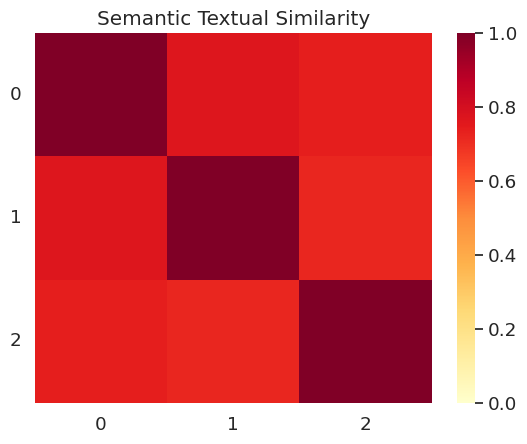

In [72]:
plot_similarity(range(3), embeddings[:3],
                0, 0)

## 1.2 Build clustering model

Since text clusters are rarely of similar sizes and most of the time, we don't know the exact number of clusters there are, this tutorial focuses on clustering methodologies that deals with non-spherical data and do not require pre-determined number of clusters. Usually hierarchical clustering models are more suitable for these needs. One such model that we will cover in this tutorial is the AgglomerativeClustering model in sklearn.

In [39]:
def cluster_with_many_ways(embeddings, way = 'complete', nsm = "cosine", thres = .7):
  """now you have the option to safety experiment with other clustering methods"""

  if way in ["ward", "single", "average"]:
    nsm = "euclidean"
    print("""The input metric {0} is not compatible with method {1}.
    Updated metric to be euclidean.""".format(nsm, way))
  # proprietary of ethelszhang@google.com, default to consine distance
  linkage_df = sch.linkage(embeddings, method = way, metric = nsm)
  threshold = thres*max(linkage_df[:,2])
  ncluster = sum([x[2] > threshold for x in linkage_df]) + 1
  # create clusters
  hc = AgglomerativeClustering(
      n_clusters = ncluster, affinity = nsm, linkage = way)
  # save clusters for chart
  y_hc = hc.fit_predict(embeddings)
  return y_hc

In [112]:
old_embeddings = embeddings
embeddings = alt_embeddings

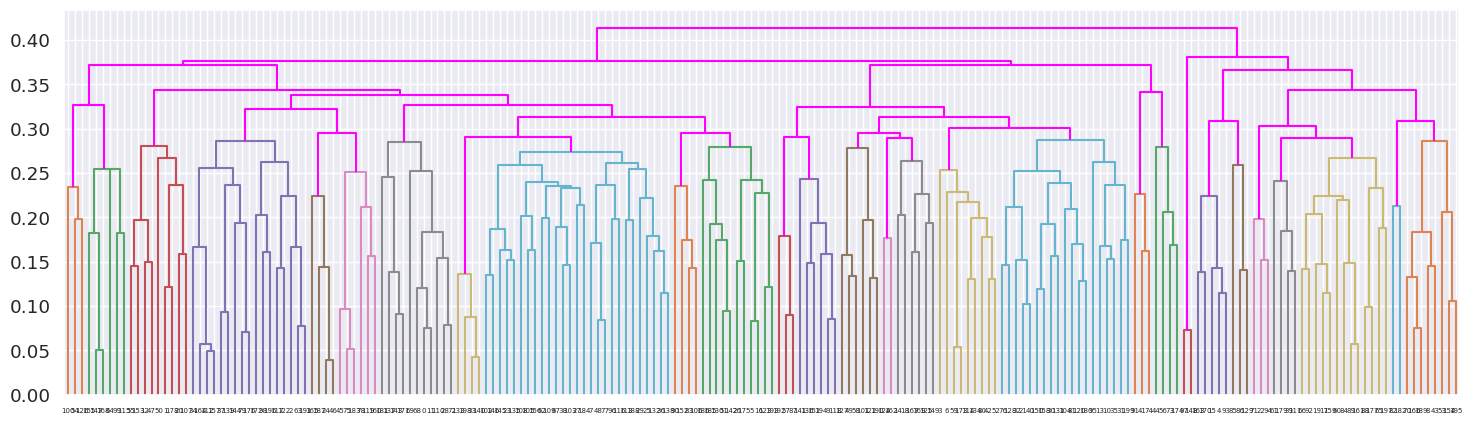

In [113]:
#@title Create dendrogram graph
plt.figure(figsize = (18, 5))
dendrogram = sch.dendrogram(
    sch.linkage(embeddings, method='complete', metric = "cosine"),
    leaf_rotation=0, above_threshold_color='magenta')
plt.hlines(1.25, 0, 1000, color = "magenta")

In [114]:
y_hc = cluster_with_many_ways(embeddings, "complete")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [115]:
output_df = pd.DataFrame([y_hc, text, intent]).T.rename(
    columns = dict(zip(range(3), ["cluster", "text", "intent"])))

## 1.3 Explore output

In [43]:
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

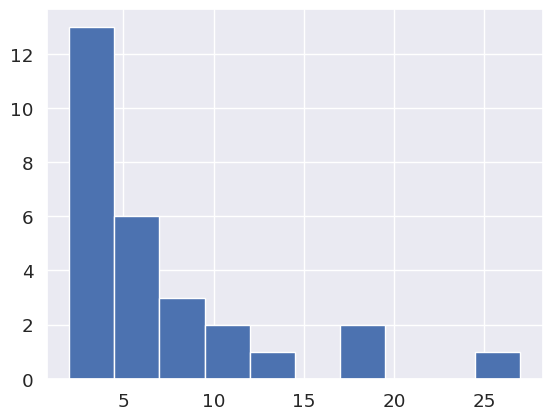

In [116]:
# distribution of cluster size
plt.hist(output_df.cluster.value_counts());

In [117]:
data_table.DataTable(
  output_df.sort_values("cluster")[["cluster", "text"]],
  num_rows_per_page=10)

,cluster,text
199,0,b'is the phone bill the same as last month'
104,0,b'my capital one visa was taken without permis...
120,0,b'i need to tell you about my lost card'
128,0,b'for my chase account can i order some checkb...
131,0,"b'is there a problem with my account , it appe..."
...,...,...
124,26,b'what is my state bank of india card credit l...
111,27,b'check the start time of the meeting schedule...
61,27,"b""is the friday 's full after 4"""
39,27,b'do i have any meetings between 1 and 8 pm'


In [118]:
#@title Get cluster centers (averages)
cluster_label_list = output_df.cluster.unique()
cluster_idx = output_df.reset_index().groupby("cluster")["index"].unique()

cluster_centers = {}
cluster_grouped = {}
for c in cluster_label_list:
  total_embeddings = [embeddings[i] for i in cluster_idx[c]]
  cluster_ctr = np.mean(total_embeddings, 0)
  cluster_centers[c] = cluster_ctr
  cluster_grouped[c] = total_embeddings

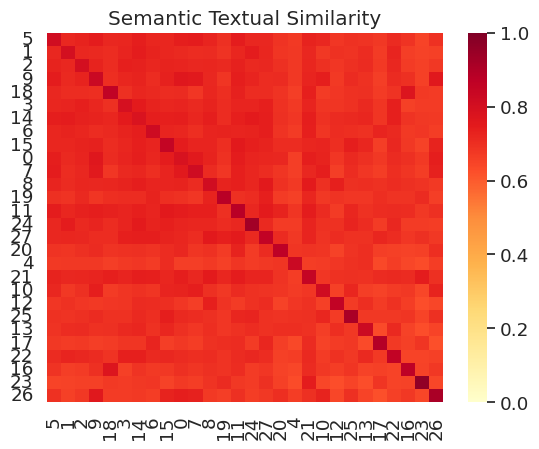

In [119]:
#@title plot cluster correlations
plot_similarity(
    list(cluster_centers.keys()), list(cluster_centers.values()), 90, 0)

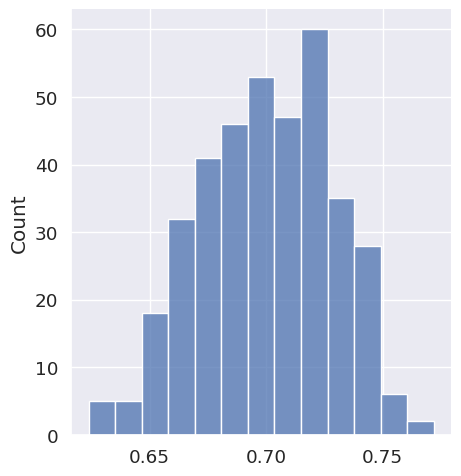

In [120]:
#@title histogram of cluster correlations
sns.displot(
  upper_tri_indexing(
    np.inner(list(cluster_centers.values()), list(cluster_centers.values()))
  )
)

## 1.4 Summarize output

In [49]:
import re
import string
import spacy
from collections import Counter
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [50]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", "")
  more_stripping =  tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')
  # source: https://stackoverflow.com/questions/66044999/remove-stopwords-in-tensorflow-extended
  return tf.strings.regex_replace(more_stripping, r'\b(' + r'|'.join(sw_spacy) + r')\b\s*',"")

In [51]:
def top_words(word_lst, n=2):
  try:
    return " * ".join([x[0] if x[1] > 1 else "NA" for x in Counter(
        [w for g in word_lst for w in set(g)]).most_common(n)])
  except:
    print("something wong")
    return ""

In [121]:
output_df["norm_text"] = custom_standardization(text)
output_df["norm_word_lst"] = output_df["norm_text"].apply(lambda x: x.decode("utf-8").split(" "))

In [122]:
cluster_df = output_df.groupby("cluster").agg({
      "norm_text":lambda x: "".join(str(x)),
      "intent":lambda x: "".join(str(x)),
      "text":np.size,
      "norm_word_lst":top_words}
    )

In [123]:
#@title invetigate how well clusters aligned with intents
data_table.DataTable(
  cluster_df.sort_values("text", ascending = False),
  num_rows_per_page=10)

,norm_text,intent,text,norm_word_lst
cluster,,,,
14,7 b'order doritos '\n23 ...,7 b'order'\n23 ...,27,* order
0,10 b'purchase'...,10 b'transactions'\n13 b...,19,account * bank
2,2 b'tires fi...,2 b'tire_pressure'\n34 ...,17,car *
8,17 b'clue taco bell takes res...,17 b'accept_reservations'\n19 b'...,13,reservations * reservation
5,0 b'know change insurance pol...,0 b'insurance_change'\n11 b'ins...,11,insurance *
3,5 b'whisper mode stop'\n1...,5 b'whisper_mode'\n16 b'whisper...,11,set *
9,3 b'come got decli...,3 b'card_declined'\n6 b...,9,credit * score
1,1 b'provide point life '\n12 ...,1 b'meaning_of_life'\n12 ...,9,tell * life
6,8 b'weather austin'\n43 b'we...,8 b'weather'\n43 ...,8,weather *


# Summarize with GenAI

In [84]:
prompt = """
You are an expert at summarizing different prompts into themes.

Summarize the following user prompts from different users into themes with one overarching theme:

{}

Think about it step by step, and show your work.
""".format(
    ".".join(output_df[output_df.cluster == 3].norm_text.apply(lambda x: x.decode("UTF-8")))
)

In [104]:
#@title GPT
if choose_model == "gpt":
  response = openai.Completion.create(
    model="text-davinci-003",
    prompt=prompt,
    # temperature=1
  )

In [105]:
if choose_model == "gpt":
  print(response['choices'][0]['text'])


Theme 1: Fun & Entertainment 
- provide point life
- tell


In [110]:
#@title PaLM
if choose_model == "palm":
  models = [m for m in palm.list_models() if 'generateText' in m.supported_generation_methods]
  gen_model = models[0].name
  print(gen_model)

models/text-bison-001


In [111]:
if choose_model == "palm":
  completion = palm.generate_text(
      model=gen_model,
      prompt=prompt,
      temperature=0,
      # The maximum length of the response
      max_output_tokens=800,
  )

  print(completion.result)

Step 1: Identify the key words in each prompt.

* provide point life -> meaning of life
* tell funny horses -> humor
* tell fun facts today -> interesting facts
* tell funny science -> humor
* tell hobbies ai -> hobbies
* monkey jokes -> humor
* kind things today -> positive news
* tell joke -> humor
* information meaning life -> meaning of life

Step 2: Group the key words into themes.

* humor
* interesting facts
* hobbies
* positive news
* meaning of life

Step 3: Identify the overarching theme.

The overarching theme is "things that make people happy".


# 2. [OPTIONAL] Write out

In [124]:
final_df = output_df.drop(columns = ["norm_word_lst"]).merge(cluster_df.drop(columns = 
 ["norm_text", "intent"]).rename(columns={"text":"cluster_size"}), on = "cluster")

In [125]:
#@title follow the authentication notification
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [126]:
final_df.to_csv('drive/My Drive/ML_TLC/gpt_output.csv')